In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd

from battleship.grammar import BattleshipGrammar
from battleship.scoring import compute_score, compute_score_parallel
from battleship.board import Board

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

In [3]:
grammar = BattleshipGrammar(include_lambdas=False)

Sampling

In [6]:
import time 
from math import ceil

dataDict = {
    'program':[],
    'board_id':[],
    'score':[],
    'max_depth':[],
    'sample_length':[]
}
df = pd.DataFrame(dataDict)

if not os.path.isfile('enumData.csv'):
   df.to_csv('enumData.csv', header='column_names')


In [7]:

def sample_baseline(cores=int(os.cpu_count()/2),sample_length=5,depth=8):
    scores = []
    for id in range(1,18+1):
        start_time = time.time()
        print(f"board {id}", end=" | ") 
        acceptable_programs = []
        while len(acceptable_programs) != sample_length: #Rejection sampling of {sample_length} programs of depth {max_depth}
            try:
                program = grammar.sample(depth)
            except:
                continue
            if program != None: #Sometimes the grammar returns a NoneType (bug?) so this is necessary 
                if "(" in program or ")" in program: #Ignores all single-token questions: a single-token question won't have brackets, so if we know a response has brackets, it is not single-token. 
                #A more robust "min-depth" parameter would parse the generated program, but this will do for one-token answers 
                    acceptable_programs.append(program)
        print(f"finished generating programs in {round(time.time()-start_time,2)}s", end=" | ")
     
        if cores != 1:
            #If more than one core is used, breaks it up into chunks of 50 programs to score in parallel as to not overwork the machine and kill the EC2 instance or the kernel.
            for i in range(ceil(sample_length/50)):
                program_scores = compute_score_parallel(programs=acceptable_programs[i*50:((i+1)*50)],board=Board.from_trial_id(id),processes=cores,show_progress=False)
                scores.extend(program_scores)
                dataDict['program'].extend(acceptable_programs[i*50:((i+1)*50)])
                dataDict['board_id'].extend([id for i in range(len(program_scores))])
                dataDict['score'].extend(program_scores)
                dataDict['max_depth'].extend([depth for i in range(len(program_scores))])
                dataDict['sample_length'].extend([sample_length for i in range(len(program_scores))])
        else:
            #If only one core is used, computes programs scores sequentially
            for prog in acceptable_programs:
                score = compute_score(program=prog, board=Board.from_trial_id(id))
                scores.append(score)
        print(f"finished scoring in {round(time.time()-start_time,2)}s from the start")

    df = pd.DataFrame(dataDict)
    df.to_csv('sampleData.csv', mode='a', header=False)
    print(f"finished {sample_length}-shot sampling at depth {depth}")
    return df

In [ ]:
samples = [1,5,10,20,25,50,100,250,500,1000,2000]
depths = [5,6,7,8,9,10]

for depth in depths:
    for sample_num in samples:
        sample_baseline(sample_length=sample_num,depth=depth)

In [17]:
df = pd.read_csv("enumData.csv")

,Unnamed: 0,program,board_id,score,max_depth,sample_length
0,0,( and ( == H V ) ( < 1 7 ) ),1,-0.000000,5,25
1,1,( color 5D ),1,-0.000000,5,25
2,2,( orient Purple ),1,0.993542,5,25
3,3,( orient Red ),1,0.993542,5,25
4,4,( orient Red ),1,0.993542,5,25
...,...,...,...,...,...,...
9445,2695,( == ( orient Red ) V ),18,-0.000000,10,25
9446,2696,( orient Blue ),18,-0.000000,10,25
9447,2697,( touch Blue Blue ),18,-0.000000,10,25
9448,2698,( > ( size Red ) ( rowL ( bottomright ( inters...,18,-0.000000,10,25


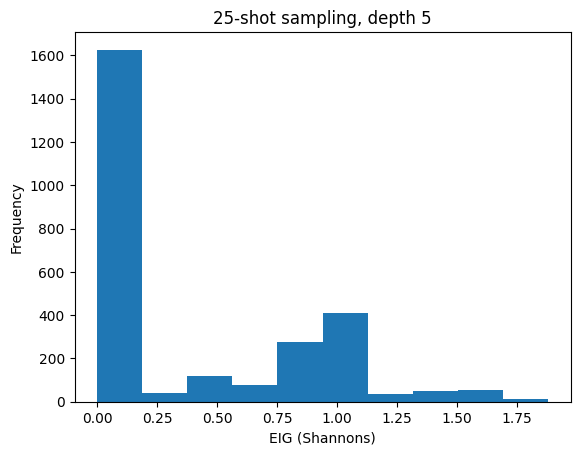

(array([ 12., 114.,  72., 132., 420., 192.,  36.,  42.,  54.,  12.]),
 array([0.112999 , 0.2896532, 0.4663074, 0.6429616, 0.8196158, 0.99627  ,
        1.1729242, 1.3495784, 1.5262326, 1.7028868, 1.879541 ]),
 <BarContainer object of 10 artists>)

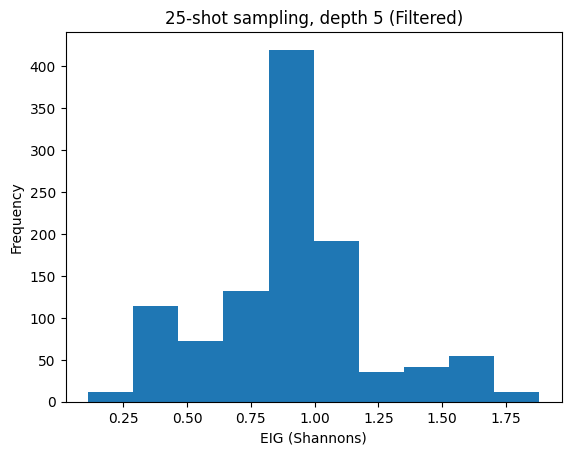

In [30]:
sample_length, depth = 25, 5

df = pd.read_csv("enumData.csv")
scores = df[df["sample_length"] == sample_length][df["max_depth"] == depth]["score"].to_list()

plt.xlabel("EIG (Shannons)")
plt.ylabel("Frequency")
plt.title(f"{sample_length}-shot sampling, depth {depth}")
plt.hist([scores])
plt.show()
plt.xlabel("EIG (Shannons)")
plt.ylabel("Frequency")
plt.title(f"{sample_length}-shot sampling, depth {depth} (Filtered)")
plt.hist([i for i in scores if i > 0])